In [1]:
# Load in dependacies
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

In [2]:
# Read in csv
df=pd.read_csv("../data/MSFT.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-08-30,57.980000,58.189999,57.610001,57.889999,53.561485,16930200
1,2016-08-31,57.650002,57.799999,57.299999,57.459999,53.163647,20860300
2,2016-09-01,57.009998,57.820000,57.009998,57.590000,53.283924,26075400
3,2016-09-02,57.669998,58.189999,57.419998,57.669998,53.357941,18900500
4,2016-09-06,57.779999,57.799999,57.209999,57.610001,53.302437,16278400


In [3]:
# Set date as index
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2016-08-30,2016-08-30,57.980000,58.189999,57.610001,57.889999,53.561485,16930200
2016-08-31,2016-08-31,57.650002,57.799999,57.299999,57.459999,53.163647,20860300
2016-09-01,2016-09-01,57.009998,57.820000,57.009998,57.590000,53.283924,26075400
2016-09-02,2016-09-02,57.669998,58.189999,57.419998,57.669998,53.357941,18900500
2016-09-06,2016-09-06,57.779999,57.799999,57.209999,57.610001,53.302437,16278400


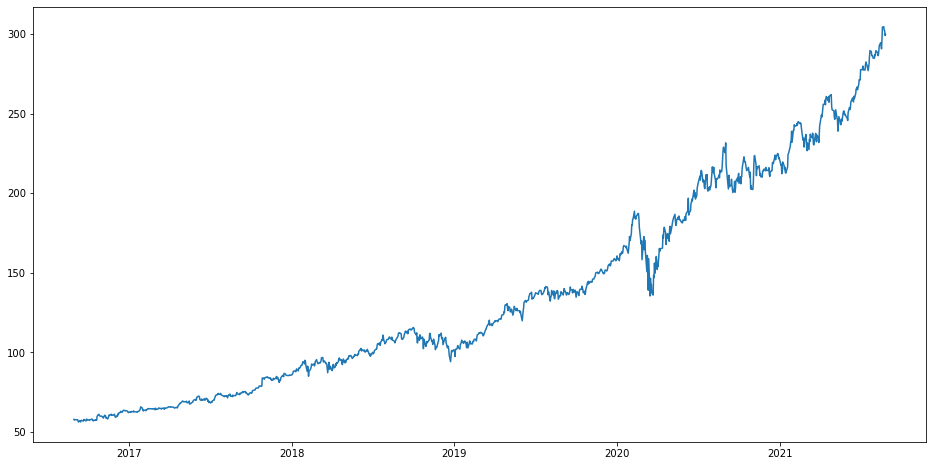

In [4]:
# Plot closing price history
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [5]:
# Import machine learning dependacies
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

In [6]:
# Sorting data
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

In [7]:
# Set up for loop for model to run through each row and scale data
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]
    

new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values

train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

In [8]:
# Train data
x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [9]:
# Use LSTM model
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

927/927 - 18s - loss: 0.0013


In [10]:
# Create inputs
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

In [11]:
# Test data
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
closing_price=lstm_model.predict(X_test)
closing_price=scaler.inverse_transform(closing_price)

In [13]:
# Save model
lstm_model.save("msft_lstm_model.h5")

<ipython-input-12-d200d491823a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=closing_price


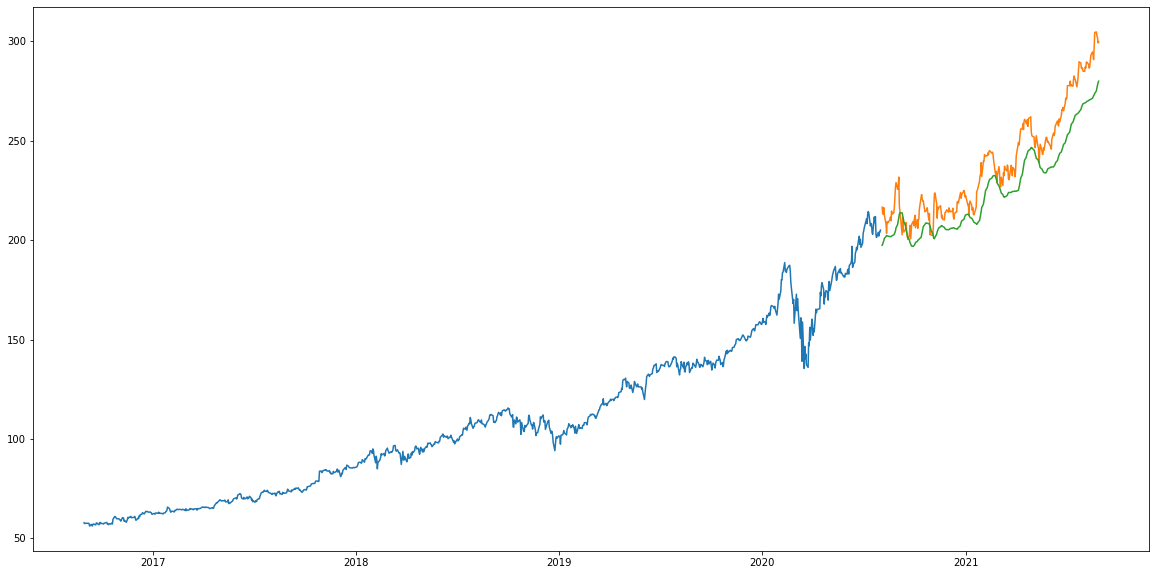

In [12]:
# Run predictions
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])